In [1]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home2/anony_ai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import json

from nltk.corpus import wordnet
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm import tqdm

class RelationshipEvaluator:
    def __init__(self, threshold=0.6, relations_list='./assets/final_cleaned_relations.json', sg='./assets/final_subset_42.json'):
        self.threshold = threshold  # Semantic similarity threshold
        self.model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')  # For embedding similarity
        
        # Load relations list
        with open(relations_list) as f:
            self.relations = json.load(f)
        
        # Process scene graph data
        with open(sg) as f:
            scene_graphs = json.load(f)
        
        # Initialize data structures
        self.object_list = {}
        self.attribute_list = {}
        self.relation_list = {}
        
        # Process each scene graph
        for sg_data in scene_graphs:
            image_id = sg_data['url']
            
            # Create object list (just names)
            self.object_list[image_id] = [obj['name'] for obj in sg_data['objects']]
            
            # Create attribute dictionary {object_id: [attributes]}
            self.attribute_list[image_id] = {}
            for attr in sg_data['attributes']:
                obj_id = attr['object']
                if obj_id not in self.attribute_list[image_id]:
                    self.attribute_list[image_id][obj_id] = []
                self.attribute_list[image_id][obj_id].append(attr['attribute'])
            
            # Create relation list (just predicates)
            self.relation_list[image_id] = [rel['predicate'] for rel in sg_data.get('relationships', [])]
        
    def load_data(self, json_path):
        
        with open(json_path, 'r') as f:
            return json.load(f)
    
    def wordnet_similarity(self, word1, word2):

        synsets1 = wordnet.synsets(word1)
        synsets2 = wordnet.synsets(word2)
        
        if not synsets1 or not synsets2:
            return 0.0
        
        max_sim = 0.0
        for syn1 in synsets1:
            for syn2 in synsets2:
                sim = syn1.wup_similarity(syn2)
                if sim is not None and sim > max_sim:
                    max_sim = sim
        return max_sim
    
    def embedding_similarity(self, word1, word2):

        embeddings = self.model.encode([word1, word2])
        return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    
    def evaluate_level3(self, data):

        results = {
            'correct': 0,
            'misclassification': 0,
            'hallucination': 0,
            'similarity_scores': [],
            'details': []
        }
        
        with open("./assets/relation_hierarchy.json", 'r') as f:
            relation_hierarchy = json.load(f)

        for item in tqdm(data):
            gt = item['ground_truth'].lower().strip()
            pred = item['prediction'].lower().strip()

            if item['word_probs']:
                pred = max(item["word_probs"].items(), key=lambda x: x[1])[0]
            
            # Calculate both similarities
            wn_sim = self.wordnet_similarity(gt, pred)
            emb_sim = self.embedding_similarity(gt, pred)
            combined_sim = (wn_sim + emb_sim) / 2  # Average of both
            
            is_correct = combined_sim >= self.threshold
            status = 'correct' if is_correct else 'hallucination'
            
            # we check if the relation is related in hierarchy
            if is_correct or pred in relation_hierarchy[gt]:
                results['correct'] += 1
            elif pred in self.relation_list[item['image_id']]:
                results['misclassification'] += 1
            else:
                results['hallucination'] += 1
            
            results['similarity_scores'].append(combined_sim)
            results['details'].append({
                'image_id': item['image_id'],
                'query': item['query'],
                'ground_truth': gt,
                'prediction': pred,
                'similarity': round(combined_sim, 4),
                'status': status
            })
        
        results['accuracy'] = results['correct'] / len(data) if len(data) > 0 else 0
        return results
    
    def evaluate_level1(self, data):
        
        results = {
            'correct': 0,
            'hallucination': 0,
            'details': []
        }

        for item in tqdm(data):
            gt = item['ground_truth'].lower().strip()
            probs = item['word_probs']

            probs_yes = probs['yes'] if 'yes' in probs else 0.0
            probs_no = probs['no'] if 'no' in probs else 0.0

            if probs_yes > probs_no:
                results['correct'] += 1
                status = "correct"
            else:
                results['hallucination'] += 1
                status = "hallucination"
            
            results['details'].append({
                'image_id': item['image_id'],
                'query': item['query'],
                'ground_truth': gt,
                'prediction': "yes" if probs_yes > probs_no else "no",
                'status': status
            })
        
        results['accuracy'] = results['correct'] / len(data) if len(data) > 0 else 0
        return results
    
    def evaluate_level2(self, data):
        results = {
            'correct': 0,
            'hallucination': 0,
            'details': []
        }

        for item in tqdm(data):
            gt = item['ground_truth'].lower().strip()
            probs = item['word_probs']

            probs_yes = probs['yes'] if 'yes' in probs else 0.0
            probs_no = probs['no'] if 'no' in probs else 0.0

            if probs_yes == 0.0 and probs_no == 0.0:
                pred = item['prediction'].lower()

                if gt in pred:
                    results['correct'] += 1
                    status = "correct"
                else:
                    results['hallucination'] += 1
                    status = "hallucination"

                results['details'].append({
                    'image_id': item['image_id'],
                    'query': item['query'],
                    'ground_truth': gt,
                    'prediction': "yes" if gt in pred else "no",
                    'status': status
                })

            else:
                if probs_yes < probs_no:
                    results['correct'] += 1
                    status = "correct"
                else:
                    results['hallucination'] += 1
                    status = "hallucination"
                
                results['details'].append({
                    'image_id': item['image_id'],
                    'query': item['query'],
                    'ground_truth': gt,
                    'prediction': "yes" if probs_yes < probs_no else "no",
                    'status': status
                })
        
        results['accuracy'] = results['correct'] / len(data) if len(data) > 0 else 0
        return results
        
    def evaluate(self, json_path, level=3):

        data = self.load_data(json_path)
        
        if level == 1:
            return self.evaluate_level1(data)
        if level == 2:
            return self.evaluate_level2(data)
        elif level == 3:
            return self.evaluate_level3(data)

/home2/anony_ai/miniconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
evaluator = RelationshipEvaluator(threshold=0.7, sg='./assets/final_subset_19.json')

# CHANGE HERE
results = evaluator.evaluate("./results/llava_level_2.json", level=2)

print(f"Accuracy: {results['accuracy']:.2%}")
print(f"Correct: {results['correct']}")
print(f"Hallucinations: {results['hallucination']}")

print("\nSample Details:")
for detail in results['details'][:3]:  # Print first 3 for demo
    print(f"Image {detail['image_id']}: {detail['status'].upper()}")
    print(f"  Query: {detail['query']}")
    print(f"  GT: {detail['ground_truth']} | Pred: {detail['prediction']}")
    # print(f"  Similarity: {detail['similarity']:.2f}\n")

100%|██████████| 1051/1051 [00:00<00:00, 579722.98it/s]

Accuracy: 65.75%
Correct: 691
Hallucinations: 360

Sample Details:
Image 615: CORRECT
  Query: Is there drum in the image?
  GT: no | Pred: yes
Image 615: CORRECT
  Query: Is there concert in the image?
  GT: no | Pred: yes
Image 615: HALLUCINATION
  Query: Does the image contain any wallet?
  GT: no | Pred: no


In [7]:
import json
from collections import defaultdict, Counter

def normalize(text):
    """Normalize answers for comparison (lowercase, strip)."""
    return text.lower().strip()

def evaluate_predictions(results_path, save_errors_path=None):
    with open(results_path, 'r') as f:
        predictions = json.load(f)

    scores = defaultdict(list)
    errors = []

    for item in predictions:
        attr_type = item['attribute_type']
        gt = normalize(item['ground_truth'])
        pred = normalize(item['prediction']['answer'])

        # Membership match
        match = gt.lower() in pred.lower()
        scores[attr_type].append(match)

        if not match and save_errors_path:
            errors.append({
                "image_id": item['image_id'],
                "query": item['query'],
                "ground_truth": gt,
                "prediction": pred
            })

    print("\n📊 Evaluation Results:")
    total_correct = 0
    total_total = 0
    for attr_type, matches in scores.items():
        correct = sum(matches)
        total = len(matches)
        acc = correct / total * 100
        total_correct += correct
        total_total += total
        print(f" - {attr_type:<10}: {correct}/{total} ({acc:.2f}%)")

    overall_acc = total_correct / total_total * 100
    print(f"\n✅ Overall Accuracy: {total_correct}/{total_total} ({overall_acc:.2f}%)")

    if save_errors_path:
        with open(save_errors_path, 'w') as f:
            json.dump(errors, f, indent=2)
        print(f"\n❌ Saved {len(errors)} errors to {save_errors_path}")

# Example usage:
evaluate_predictions(
    results_path="./results/llava_level_attr.json",
    save_errors_path="vlm_attribute_errors.json"
)



📊 Evaluation Results:
 - color     : 348/618 (56.31%)
 - material  : 14/43 (32.56%)
 - condition : 1/12 (8.33%)
 - shape     : 5/9 (55.56%)

✅ Overall Accuracy: 368/682 (53.96%)

❌ Saved 314 errors to vlm_attribute_errors.json


/tmp/ipykernel_19856/3441535338.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acc_sorted, y=attr_types_sorted, palette="viridis")


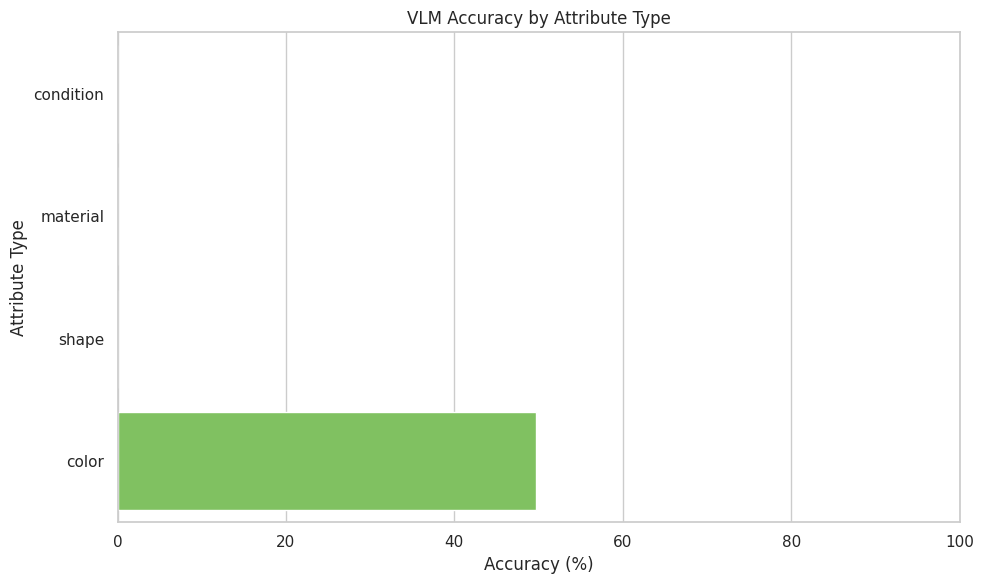

In [4]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def normalize(text):
    return text.lower().strip()

def evaluate_and_plot(results_path):
    with open(results_path, 'r') as f:
        predictions = json.load(f)

    scores = defaultdict(list)

    for item in predictions:
        attr_type = item['attribute_type']
        gt = normalize(item['answer_gt'])
        pred = normalize(item['answer_vlm'])
        match = gt == pred
        scores[attr_type].append(match)

    # Compute accuracy per attribute type
    accuracies = {k: sum(v)/len(v)*100 for k, v in scores.items()}
    attr_types = list(accuracies.keys())
    acc_values = list(accuracies.values())

    # Sort for clean plot
    attr_types_sorted = sorted(attr_types, key=lambda x: accuracies[x])
    acc_sorted = [accuracies[attr] for attr in attr_types_sorted]

    # Plotting
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=acc_sorted, y=attr_types_sorted, palette="viridis")
    plt.xlabel("Accuracy (%)")
    plt.ylabel("Attribute Type")
    plt.title("VLM Accuracy by Attribute Type")
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()

# Example usage:
evaluate_and_plot("vlm_attribute_evaluation_results.json")
